# Case Study 2 : Pneumonia

Tha Songtan Suppasadid<br>
Nichakan Udomlerkchai<br>
Peeranon Posawang<br>

Last edited: 2/28/2020 9:43 AM<br>
Helsinki Metropolia University of Applied Science


## Background

&emsp; This document is created for the diagnosis of pneumonia which is an infection in lungs by bacteria, viruses or fungi by using Convolutional Neural Network Model (CNN). The infection causes inflammation in the air sacs in your lungs, making the patient difficult to breathe. <br>
&emsp; 3 models are created. The first one is basic CNNs model. The second one is basic CNNs model with class weight to handle imbalance class. The last one is using pretrained neural network (VGG16) to extract feature. The inputs of models are chest x-rayed images so we are going to use an image processing method to predict the result of the diagnosis of pneumonia. These are the samples of x-rayed images of lungs. The left one is infected and the right one is healthy lungs.

## Data

&emsp; The data is retrieved from data.mendeley.com and responsibly collected by Daniel Kermany, Kang Zhang and Michael Goldbaum from University of California San Diego which is published on 6 Jan 2018. The data is version 2.
Total 5,856‬ OCT images are split into a training set, a validation set and a testing set. The dataset also split into 2 directories which are PNEUMONIA and NORMAL.

Below is the amount samples in each set;<br>
training-normal:  948<br>
training-pneumonia: 2564<br>
total training: 3512<br>

validation-normal: 317<br>
validation-pneumonia: 855<br>
total validation: 1172<br>

test-normals: 317<br>
test-pneumonia: 855<br>
total validation: 1172<br>

Total samples: 5856

The ratio of train:test:validation set is 60-20-20<br>
The ratio of normal:pneumonia in each set is 27:73

In [1]:
from tensorflow import keras
from tensorflow.keras import layers,models,optimizers,metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve,auc

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
# Create empty dictionary for result
result = {}

In [5]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [6]:
# Data Set path from Kaggle
# train_dir = '/kaggle/input/case2-data/Case2_XRay/train/'
# test_dir = '/kaggle/input/case2-data/Case2_XRay/test/'
# validation_dir = '/kaggle/input/case2-data/Case2_XRay/validation/'

In [7]:
#Data Set path for local dataset
#Use this one
train_dir = 'Case2_XRay/train/'
test_dir = 'Case2_XRay/test/'
validation_dir = 'Case2_XRay/validation/'

In [8]:
#Create generator object for each set
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                                 )
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

All pixel value in each 3 sets should be rescaled from 0-255 to 0-1 to reduce complexity of model computation.
We augmented only training set because the test and validation set should not be modified much. We augmented the training set to reduce the risk of overfitting caused by feeding a lot of similar images. Augmentation is done by slightly adjusting image such as rotate, translate, zoom and flip.

In [9]:
#Create 3 input objects
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 439,  # 439 is from 3512/8. 439*8 is the biggest pair if we want to use the whole dataset
    class_mode = "binary")

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 293, # 293 is from 1172/4. 293*4 is the biggest pair if we want to use the whole dataset
    shuffle = False,
    class_mode = "binary")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 293, # 293 is from 1172/4. 293*4 is the biggest pair if we want to use the whole dataset
    shuffle = False,
    class_mode = "binary")

Found 3512 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


The ratio of train:test:validation set is 60-20-20<br>
The ratio of normal:pneumonia in each set is 27:73

## Models and training

## Model 1: Basic CNNs model

In [10]:
#Create convolutional layer
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

#Flatten convoluted input 
model.add(layers.Flatten())

#Add classification layers
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [11]:
# Check Layer and number of free variables of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        9

In [12]:
#Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.FalseNegatives(),metrics.SensitivityAtSpecificity(0.9),'acc']
             )

We interested in False Negatives values, Sensitivity at 90% Specificity and Accuracy. <br>
The reason we want to look at False Negatives because we do not want sick patient to be identified as normal, which may result in improper treatment. <br>
For Sensitivity at 90% Specificity we want to check that if we can identifies 90% of normal people, how much sick people we can identify. <br>
and for Accuracy, we want to check the correct prediction of our model compare to the total prediction

In [13]:
#Show time of model training
start_time = time.time()

#Train model
history = model.fit_generator(train_generator,
                              steps_per_epoch = 8, # 439*8 = 3512
                              verbose = 0,
                              epochs = 8, # 2**3
                              validation_data = validation_generator,
                              validation_steps = 4, # 293*4 = 1172
            )
training_time = str(int((time.time() - start_time)//60)) + " minutes and " + str((time.time() - start_time)%60)[0:5] + " seconds"
print(f"Trainning time = {training_time}")

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Trainning time = 15 minutes and 50.78 seconds


In [14]:
#Check for the keys of model training history
history.history.keys()

dict_keys(['loss', 'false_negatives', 'sensitivity_at_specificity', 'acc', 'val_loss', 'val_false_negatives', 'val_sensitivity_at_specificity', 'val_acc'])

In [15]:
#Get value to draw training loss, validation loss, false negatives and sensitivity at specificity graph
loss = history.history['loss']
fn = history.history['false_negatives']
acc = history.history['acc']
sas = history.history['sensitivity_at_specificity']
val_loss = history.history['val_loss']
val_fn = history.history['val_false_negatives']
val_acc = history.history['val_acc']
val_sas = history.history['val_sensitivity_at_specificity']
epochs = range(len(acc))

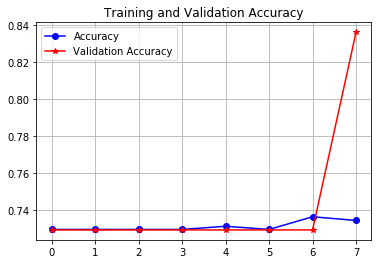

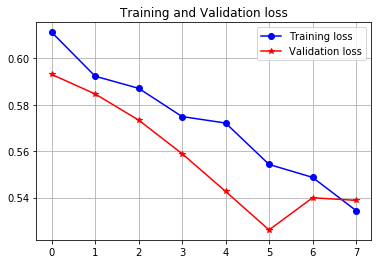

In [16]:
#Plot training and validation accuracy graph, training and validation loss graph
plt.plot(epochs,acc,'bo-',label="Accuracy")
plt.plot(epochs,val_acc,'r*-',label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.plot(epochs,val_loss,'r*-',label="Validation loss")
plt.title('Training and Validation loss')
plt.grid()
plt.legend()

plt.show()

The Validation Accuracy Graph look strange.

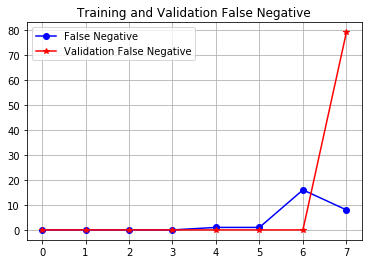

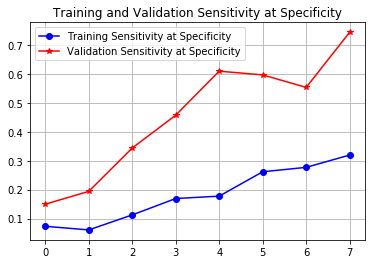

In [17]:
#Plot training and validation false negative, training and validation sensitivity at specificity graph
plt.figure()
plt.plot(epochs,fn,'bo-',label="False Negative")
plt.plot(epochs,val_fn,'r*-',label="Validation False Negative")
plt.title('Training and Validation False Negative')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,sas,'bo-',label="Training Sensitivity at Specificity")
plt.plot(epochs,val_sas,'r*-',label="Validation Sensitivity at Specificity")
plt.title('Training and Validation Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.show()

Validation False Negative graph also look a bit strange.

Instructions for updating:
Please use Model.predict, which supports generators.


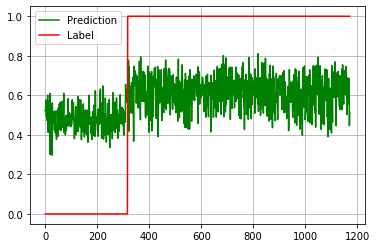

In [18]:
#Plot prediction vs label
labels = test_generator.classes
predictions = model.predict_generator(validation_generator).flatten()
plt.plot(predictions, label = 'Prediction', color = 'g')
plt.plot(labels, label = 'Label', color = 'r')
plt.legend()
plt.grid()

In [19]:
#Predict and Compute prediction time.
start_time = time.time()
predictions = model.predict_generator(test_generator)
print(f"Predicting time = {int((time.time() - start_time)/60)} minutes and {int((time.time() - start_time)%60)} seconds")

Predicting time = 0 minutes and 26 seconds


In [20]:
# reshape prediction to be 1 dimension array
y_pred = predictions.reshape(predictions.shape[0])

In [21]:
# get true label from the test generator
y_true = test_generator.classes

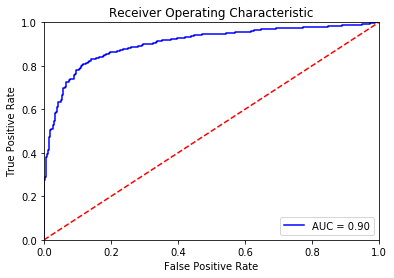

In [22]:
# plot ROC-curve
fpr, tpr, threshold = roc_curve(y_true,y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

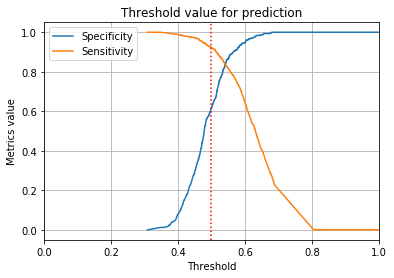

In [23]:
#Find the best threshold
plt.plot(threshold, 1 -fpr, label = 'Specificity')
plt.plot(threshold, tpr, label = 'Sensitivity')
plt.axvline(0.5, color = 'red', linestyle = ':')
plt.xlim([0,1])
plt.title('Threshold value for prediction')
plt.xlabel('Threshold')
plt.ylabel('Metrics value')
plt.legend()
plt.grid()
plt.show()

In this model we choose 0.55 as threshold of prediction, which is the point that has highest sensitivity and specificity at the same time

In [24]:
y_pred = 1.0*(predictions > 0.55).reshape(predictions.shape[0])

In [25]:
#Show confusion matrix and some other metrics
cm = confusion_matrix(y_true, y_pred)

print(cm)
print(classification_report(y_true, y_pred))

m1 = metrics.SensitivityAtSpecificity(0.9)
m1.update_state(y_true, predictions.reshape(predictions.shape[0]))
print(f"Sensitivity at 90% Specificity = {m1.result().numpy()}")

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print(f"Sensitivity(Recall) = {sensitivity}")
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Specificity = {specificity}")

m2 = metrics.FalseNegatives()
m2.update_state(y_true, y_pred.reshape(predictions.shape[0]))
falseneg = m2.result().numpy()
print(f"False negative = {falseneg}")

m3 = metrics.Accuracy()
m3.update_state(y_true, y_pred.reshape(predictions.shape[0]))
acc = m3.result().numpy()
print(f"Accuracy = {acc}")

fbeta_sklearn = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 score = {fbeta_sklearn}")

# Save result in the result dictionary
result["Model 1"] = {"Sensitivity":sensitivity,
                     "Specificity":specificity,
                     "False Negative":falseneg,
                     "Accuracy":acc,
                     "F2 Score":fbeta_sklearn,
                     "Training Time":training_time
                    }

[[275  42]
 [159 696]]
              precision    recall  f1-score   support

           0       0.63      0.87      0.73       317
           1       0.94      0.81      0.87       855

    accuracy                           0.83      1172
   macro avg       0.79      0.84      0.80      1172
weighted avg       0.86      0.83      0.84      1172

Sensitivity at 90% Specificity = 0.7836257219314575
Sensitivity(Recall) = 0.8140350877192982
Specificity = 0.8675078864353313
False negative = 159.0
Accuracy = 0.8284983038902283
F2 score = 0.836940836940837


# Model 2 with weight

In [26]:
from sklearn.utils import class_weight

In [27]:
# use class weight to  handle imbalance class. More detail in Result and Discussion
weights = class_weight.compute_class_weight('balanced',np.unique(train_generator.classes),train_generator.classes)
print(weights)

[1.85036881 0.68513461]


In [28]:
c_w = {0:weights[0],1:weights[1]}

In [29]:
#Create convolutional layer
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

#Create convolutional input
model.add(layers.Flatten())

#Add classification layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

# model.summary()
# Note that model 1 and 2 architecture are the same but we implement class weight in Model 2

In [30]:
#Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.FalseNegatives(),metrics.SensitivityAtSpecificity(0.9),'acc']
             )

In [31]:
#Show time of model training
start_time = time.time()

#Train model
history2 = model.fit_generator(train_generator,
                              steps_per_epoch = 8,
                              verbose = 0,
                              epochs = 8,
                              validation_data = validation_generator,
                              validation_steps = 4,
                              class_weight=c_w
            )
training_time = str(int((time.time() - start_time)//60)) + " minutes and " + str((time.time() - start_time)%60)[0:5] + " seconds"
print(f"Training time = {training_time}")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training time = 16 minutes and 48.73 seconds


In [32]:
#Check for the keys of model training history
history2.history.keys()

dict_keys(['loss', 'false_negatives_2', 'sensitivity_at_specificity_2', 'acc', 'val_loss', 'val_false_negatives_2', 'val_sensitivity_at_specificity_2', 'val_acc'])

In [34]:
#Get value to draw training loss, validation loss, false negatives and sensitivity at specificity graph
loss = history2.history['loss']
fn = history2.history['false_negatives_2']
acc = history2.history['acc']
sas = history2.history['sensitivity_at_specificity_2']
val_loss = history2.history['val_loss']
val_fn = history2.history['val_false_negatives_2']
val_acc = history2.history['val_acc']
val_sas = history2.history['val_sensitivity_at_specificity_2']
epochs = range(len(acc))

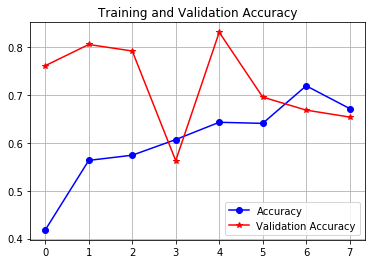

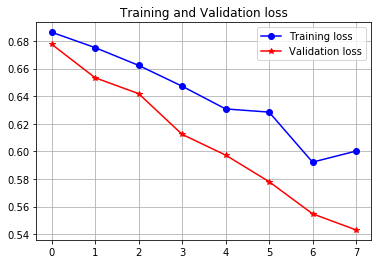

In [35]:
#Draw training and validation accuracy, training and validation loss
plt.plot(epochs,acc,'bo-',label="Accuracy")
plt.plot(epochs,val_acc,'r*-',label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.plot(epochs,val_loss,'r*-',label="Validation loss")
plt.title('Training and Validation loss')
plt.grid()
plt.legend()

plt.show()

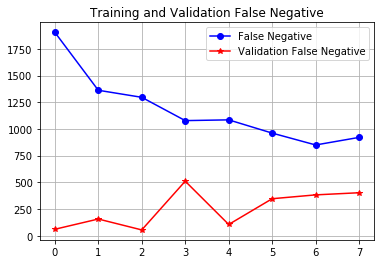

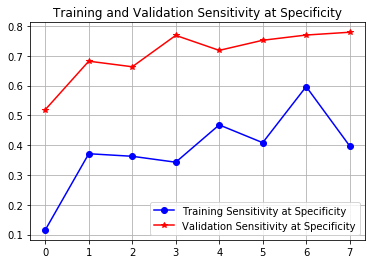

In [36]:
#Draw training and validation false negative, training and validation sensitivity at specificity graph
plt.figure()
plt.plot(epochs,fn,'bo-',label="False Negative")
plt.plot(epochs,val_fn,'r*-',label="Validation False Negative")
plt.title('Training and Validation False Negative')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,sas,'bo-',label="Training Sensitivity at Specificity")
plt.plot(epochs,val_sas,'r*-',label="Validation Sensitivity at Specificity")
plt.title('Training and Validation Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.show()

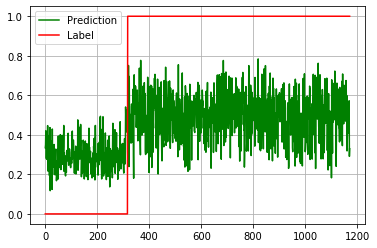

In [37]:
#Plot prediction vs label
labels = test_generator.classes
predictions = model.predict_generator(validation_generator).flatten()
plt.plot(predictions, label = 'Prediction', color = 'g')
plt.plot(labels, label = 'Label', color = 'r')
plt.legend()
plt.grid()

In [38]:
#Predict and Compute prediction time.
start_time = time.time()
predictions = model.predict_generator(test_generator)
print(f"Predicting time = {int((time.time() - start_time)/60)} minutes and {int((time.time() - start_time)%60)} seconds")

Predicting time = 0 minutes and 28 seconds


In [39]:
# reshape prediction to 1D array
y_pred = predictions.reshape(predictions.shape[0])

In [40]:
# Get true label from generator object
y_true = test_generator.classes

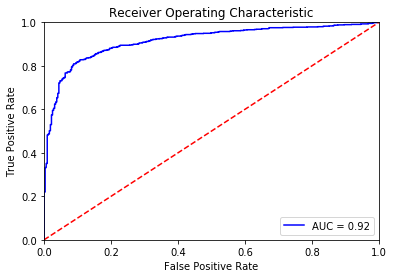

In [41]:
# Plot ROC-curve
fpr, tpr, threshold = roc_curve(y_true,y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

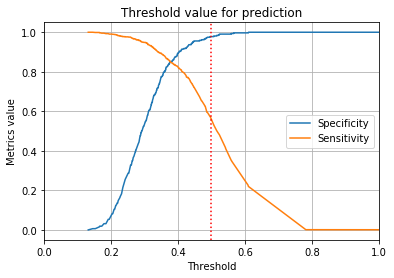

In [42]:
#Find the best threshold
plt.plot(threshold, 1 -fpr, label = 'Specificity')
plt.plot(threshold, tpr, label = 'Sensitivity')
plt.axvline(0.5, color = 'red', linestyle = ':')
plt.xlim([0,1])
plt.title('Threshold value for prediction')
plt.xlabel('Threshold')
plt.ylabel('Metrics value')
plt.legend()
plt.grid()
plt.show()

In this model we choose 0.38 as threshold of prediction, which is the point that has highest sensitivity and specificity at the same time

In [43]:
y_pred = 1.0*(predictions > 0.38).reshape(predictions.shape[0])

In [44]:
#Show confusion matrix and some other metrics
cm = confusion_matrix(y_true, y_pred)

print(cm)
print(classification_report(y_true, y_pred))

m1 = metrics.SensitivityAtSpecificity(0.9)
m1.update_state(y_true, predictions.reshape(predictions.shape[0]))
print(f"Sensitivity at 90% Specificity = {m1.result().numpy()}")

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print(f"Sensitivity(Recall) = {sensitivity}")
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Specificity = {specificity}")

m2 = metrics.FalseNegatives()
m2.update_state(y_true, y_pred.reshape(predictions.shape[0]))
falseneg = m2.result().numpy()
print(f"False negative = {falseneg}")

m3 = metrics.Accuracy()
m3.update_state(y_true, y_pred.reshape(predictions.shape[0]))
acc = m3.result().numpy()
print(f"Accuracy = {acc}")

fbeta_sklearn = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 score = {fbeta_sklearn}")

# Save result in the result dictionary
result["Model 2"] = {"Sensitivity":sensitivity,
                     "Specificity":specificity,
                     "False Negative":falseneg,
                     "Accuracy":acc,
                     "F2 Score":fbeta_sklearn,
                     "Training Time":training_time
                    }

[[270  47]
 [131 724]]
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       317
           1       0.94      0.85      0.89       855

    accuracy                           0.85      1172
   macro avg       0.81      0.85      0.82      1172
weighted avg       0.87      0.85      0.85      1172

Sensitivity at 90% Specificity = 0.8187134265899658
Sensitivity(Recall) = 0.8467836257309942
Specificity = 0.8517350157728707
False negative = 131.0
Accuracy = 0.8481228947639465
F2 score = 0.8637556669052732


# Model 3 Using Pretrained ConvNet (VGG16)

In [45]:
# Training Set Shuffle needs to be False now but other sets are already False
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 439,
    shuffle = False,
    class_mode = "binary")

Found 3512 images belonging to 2 classes.


In [46]:
# Prepare Label for Training and Test set
# because train and test generator will have to go in VGG16 for feature extraction
# note that there are no validation because we cannot figure out how to put validation label into the model
train_labels = train_generator.classes
train_generator.class_mode = False
test_labels = test_generator.classes
test_generator.class_mode = False

In [47]:
start_time = time.time()
# Create VGG16 model object
conv_base = keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

In [48]:
# Set VGG16 object to be untrainable
conv_base.trainable = False

In [49]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [50]:
# Extract feature of training set using VGG16
feature_batch =  conv_base.predict(train_generator)

In [51]:
# Check the shape of our new training set
feature_batch.shape

(3512, 4, 4, 512)

In [52]:
# Extract feature of test set using VGG16
feature_batch_test =  conv_base.predict(test_generator)

In [53]:
# Check the shape of our new test set
feature_batch_test.shape

(1172, 4, 4, 512)

In [54]:
# Create Classification Layer, which is the same as 2 models above
model = models.Sequential()
model.add(layers.Flatten(input_shape=(4, 4, 512)))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 4,195,329
Trainable params: 4,195,329
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Compile Classification layer model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.FalseNegatives(),metrics.SensitivityAtSpecificity(0.9),'acc']
             )

In [56]:
# Train Classification Layer
history = model.fit(feature_batch,
                    train_labels,
                    steps_per_epoch = 8,verbose = 0,
                    epochs = 8,
                    use_multiprocessing = True,
            )
# Show Traing time + Feature extraction time
training_time = str(int((time.time() - start_time)//60)) + " minutes and " + str((time.time() - start_time)%60)[0:5] + " seconds"
print(f"Training time = {training_time}")

Training time = 9 minutes and 19.42 seconds


In [57]:
history.history.keys()

dict_keys(['loss', 'false_negatives_4', 'sensitivity_at_specificity_4', 'acc'])

In [59]:
loss = history.history['loss']
fn = history.history['false_negatives_4']
acc = history.history['acc']
sas = history.history['sensitivity_at_specificity_4']
epochs = range(len(acc))

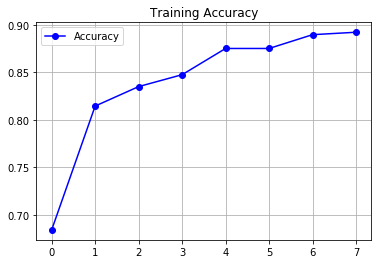

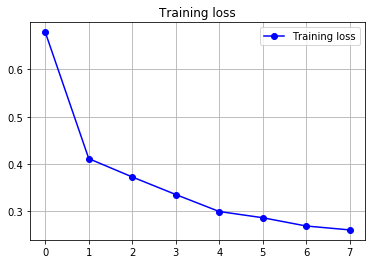

In [60]:
# Plot Training Accuracy of each Epoch
plt.plot(epochs,acc,'bo-',label="Accuracy")
plt.title('Training Accuracy')
plt.grid()
plt.legend()

# Plot Training Loss of each Epoch
plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.title('Training loss')
plt.grid()
plt.legend()

plt.show()

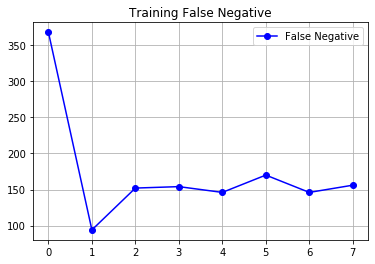

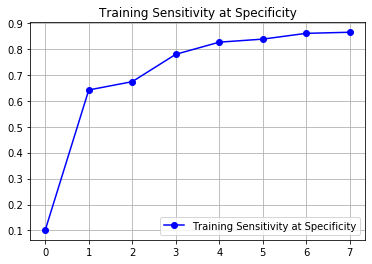

In [61]:
# Plot Training False Negative of each Epoch
plt.figure()
plt.plot(epochs,fn,'bo-',label="False Negative")
plt.title('Training False Negative')
plt.grid()
plt.legend()

# Plot Training Sensitivity at 90% Specificity of each Epoch
plt.figure()
plt.plot(epochs,sas,'bo-',label="Training Sensitivity at Specificity")
plt.title('Training Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.show()

In [62]:
# Get flattened prediction
predictions = model.predict_generator(feature_batch_test).flatten()

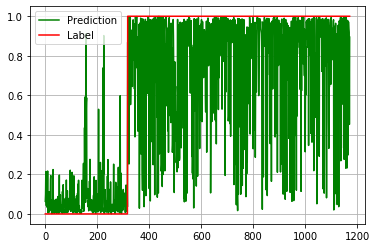

In [63]:
#Plot prediction vs label
plt.plot(predictions, label = 'Prediction', color = 'g')
plt.plot(test_labels, label = 'Label', color = 'r')
plt.legend()
plt.grid()

In [64]:
y_pred = predictions
# Change name of variable for a bit easier coding
y_true = test_labels

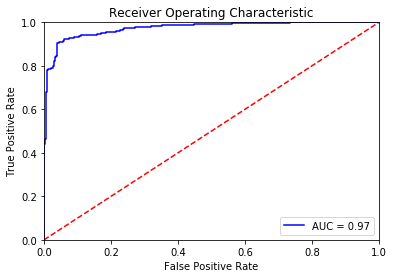

In [65]:
# Plot ROC-curve
fpr, tpr, threshold = roc_curve(y_true,y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

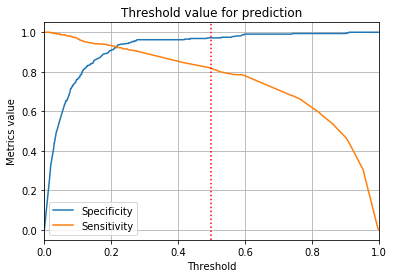

In [66]:
#Find the best threshold
plt.plot(threshold, 1 -fpr, label = 'Specificity')
plt.plot(threshold, tpr, label = 'Sensitivity')
plt.axvline(0.5, color = 'red', linestyle = ':')
plt.xlim([0,1])
plt.title('Threshold value for prediction')
plt.xlabel('Threshold')
plt.ylabel('Metrics value')
plt.legend()
plt.grid()
plt.show()

In this model we choose 0.21 as threshold of prediction, which is the point that has highest sensitivity and specificity at the same time

In [67]:
y_pred = 1.0*(predictions > 0.21)

In [68]:
#Show confusion matrix and some other metrics
cm = confusion_matrix(y_true, y_pred)

print(cm)
print(classification_report(y_true, y_pred))

m1 = metrics.SensitivityAtSpecificity(0.9)
m1.update_state(y_true, predictions.reshape(predictions.shape[0]))
print(f"Sensitivity at 90% Specificity = {m1.result().numpy()}")

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print(f"Sensitivity(Recall) = {sensitivity}")
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Specificity = {specificity}")

m2 = metrics.FalseNegatives()
m2.update_state(y_true, y_pred.reshape(predictions.shape[0]))
falseneg = m2.result().numpy()
print(f"False negative = {falseneg}")

m3 = metrics.Accuracy()
m3.update_state(y_true, y_pred.reshape(predictions.shape[0]))
acc = m3.result().numpy()
print(f"Accuracy = {acc}")

fbeta_sklearn = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 score = {fbeta_sklearn}")

# Save result in the result dictionary
result["Model 3"] = {"Sensitivity":sensitivity,
                     "Specificity":specificity,
                     "False Negative":falseneg,
                     "Accuracy":acc,
                     "F2 Score":fbeta_sklearn,
                     "Training Time":training_time
                    }

[[291  26]
 [ 60 795]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       317
           1       0.97      0.93      0.95       855

    accuracy                           0.93      1172
   macro avg       0.90      0.92      0.91      1172
weighted avg       0.93      0.93      0.93      1172

Sensitivity at 90% Specificity = 0.934502899646759
Sensitivity(Recall) = 0.9298245614035088
Specificity = 0.917981072555205
False negative = 60.0
Accuracy = 0.92662113904953
F2 score = 0.9372789436453667


# Model 4 Using Pretrained ConvNet (VGG16) with Class Weight

In [69]:
c_w = {0:weights[0],1:weights[1]}
print(c_w)

{0: 1.850368809272919, 1: 0.685134607881389}


In [70]:
# Training Set Shuffle needs to be False now but other sets are already False
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 439,
    shuffle = False,
    class_mode = "binary")

Found 3512 images belonging to 2 classes.


In [71]:
# Prepare Label for Training and Test set
# because train and test generator will have to go in VGG16 for feature extraction
# note that there are no validation because we cannot figure out how to put validation label into the model
train_labels = train_generator.classes
train_generator.class_mode = False
test_labels = test_generator.classes
test_generator.class_mode = False

In [72]:
start_time = time.time()
# Create VGG16 model object
conv_base = keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))
# Set VGG16 object to be untrainable
conv_base.trainable = False
# Extract feature of training set using VGG16
feature_batch =  conv_base.predict(train_generator)
# Extract feature of test set using VGG16
feature_batch_test =  conv_base.predict(test_generator)

In [73]:
# Create Classification Layer, which is the same as 3 models above
model = models.Sequential()
model.add(layers.Flatten(input_shape=(4, 4, 512)))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

#model.summary()

In [74]:
# Compile Classification layer model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = [metrics.FalseNegatives(),metrics.SensitivityAtSpecificity(0.9),'acc']
             )

In [75]:
# Train Classification Layer
history = model.fit(feature_batch,
                    train_labels,
                    steps_per_epoch = 8,verbose = 0,
                    epochs = 8,
                    class_weight = c_w,
                    use_multiprocessing = True,
            )
# Show Traing time + Feature extraction time
training_time = str(int((time.time() - start_time)//60)) + " minutes and " + str((time.time() - start_time)%60)[0:5] + " seconds"
print(f"Training time = {training_time}")

  ...
    to  
  ['...']
Training time = 9 minutes and 28.10 seconds


In [76]:
history.history.keys()

dict_keys(['loss', 'false_negatives_6', 'sensitivity_at_specificity_6', 'acc'])

In [78]:
loss = history.history['loss']
fn = history.history['false_negatives_6']
acc = history.history['acc']
sas = history.history['sensitivity_at_specificity_6']
epochs = range(len(acc))

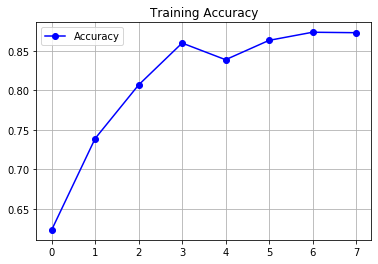

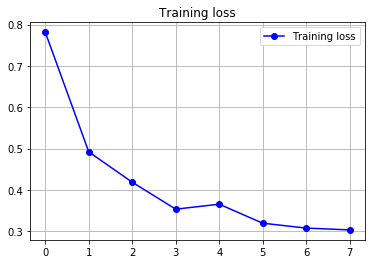

In [79]:
# Plot Training Accuracy of each Epoch
plt.plot(epochs,acc,'bo-',label="Accuracy")
plt.title('Training Accuracy')
plt.grid()
plt.legend()

# Plot Training Loss of each Epoch
plt.figure()
plt.plot(epochs,loss,'bo-',label="Training loss")
plt.title('Training loss')
plt.grid()
plt.legend()

plt.show()

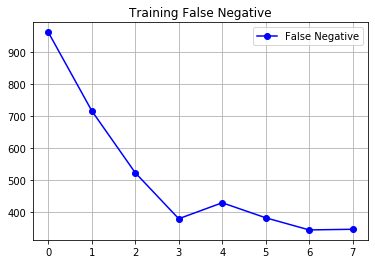

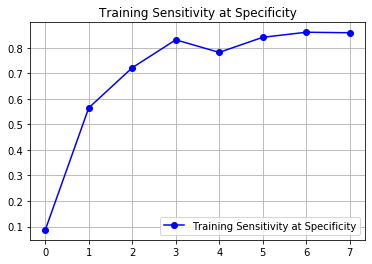

In [80]:
# Plot Training False Negative of each Epoch
plt.figure()
plt.plot(epochs,fn,'bo-',label="False Negative")
plt.title('Training False Negative')
plt.grid()
plt.legend()

# Plot Training Sensitivity at 90% Specificity of each Epoch
plt.figure()
plt.plot(epochs,sas,'bo-',label="Training Sensitivity at Specificity")
plt.title('Training Sensitivity at Specificity')
plt.grid()
plt.legend()

plt.show()

In [81]:
# Get flattened prediction
predictions = model.predict_generator(feature_batch_test).flatten()

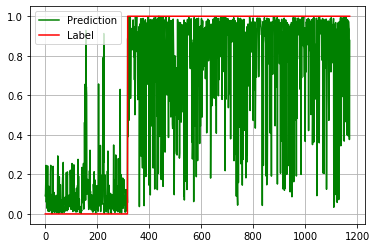

In [82]:
#Plot prediction vs label
plt.plot(predictions, label = 'Prediction', color = 'g')
plt.plot(labels, label = 'Label', color = 'r')
plt.legend()
plt.grid()

In [83]:
y_pred = predictions
# Change name of variable for a bit easier coding
y_true = test_labels

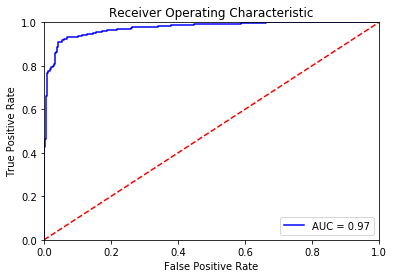

In [84]:
# Plot ROC-curve
fpr, tpr, threshold = roc_curve(y_true,y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

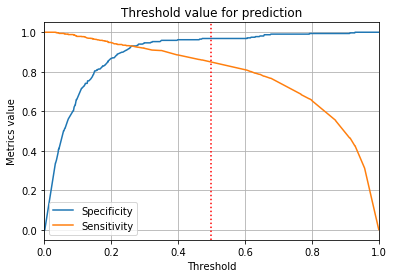

In [85]:
#Find the best threshold
plt.plot(threshold, 1 -fpr, label = 'Specificity')
plt.plot(threshold, tpr, label = 'Sensitivity')
plt.axvline(0.5, color = 'red', linestyle = ':')
plt.xlim([0,1])
plt.title('Threshold value for prediction')
plt.xlabel('Threshold')
plt.ylabel('Metrics value')
plt.legend()
plt.grid()
plt.show()

In this model we choose 0.26 as threshold of prediction, which is the point that has highest sensitivity and specificity at the same time

In [86]:
y_pred = 1.0*(predictions > 0.26)

In [87]:
#Show confusion matrix and some other metrics
cm = confusion_matrix(y_true, y_pred)

print(cm)
print(classification_report(y_true, y_pred))

m1 = metrics.SensitivityAtSpecificity(0.9)
m1.update_state(y_true, predictions.reshape(predictions.shape[0]))
print(f"Sensitivity at 90% Specificity = {m1.result().numpy()}")

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print(f"Sensitivity(Recall) = {sensitivity}")
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print(f"Specificity = {specificity}")

m2 = metrics.FalseNegatives()
m2.update_state(y_true, y_pred.reshape(predictions.shape[0]))
falseneg = m2.result().numpy()
print(f"False negative = {falseneg}")

m3 = metrics.Accuracy()
m3.update_state(y_true, y_pred.reshape(predictions.shape[0]))
acc = m3.result().numpy()
print(f"Accuracy = {acc}")

fbeta_sklearn = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 score = {fbeta_sklearn}")

# Save result in the result dictionary
result["Model 4"] = {"Sensitivity":sensitivity,
                     "Specificity":specificity,
                     "False Negative":falseneg,
                     "Accuracy":acc,
                     "F2 Score":fbeta_sklearn,
                     "Training Time":training_time
                    }

[[294  23]
 [ 59 796]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       317
           1       0.97      0.93      0.95       855

    accuracy                           0.93      1172
   macro avg       0.90      0.93      0.91      1172
weighted avg       0.93      0.93      0.93      1172

Sensitivity at 90% Specificity = 0.9380117058753967
Sensitivity(Recall) = 0.9309941520467836
Specificity = 0.9274447949526814
False negative = 59.0
Accuracy = 0.9300341010093689
F2 score = 0.9389006841236139


## Results and Discussion

In [88]:
# Show Result table of our Experiment
pd.DataFrame.from_dict(result).transpose()

,Sensitivity,Specificity,False Negative,Accuracy,F2 Score,Training Time
Model 1,0.814035,0.867508,159,0.828498,0.836941,15 minutes and 50.78 seconds
Model 2,0.846784,0.851735,131,0.848123,0.863756,16 minutes and 48.73 seconds
Model 3,0.929825,0.917981,60,0.926621,0.937279,9 minutes and 19.42 seconds
Model 4,0.930994,0.927445,59,0.930034,0.938901,9 minutes and 28.10 seconds


&emsp;From the table Model 2 is slightly better than Model 1 (only little sensivity drop) after we handle imbalance class with class weight.<br>
Imbalance class happen when the labels of Data are not equally distribute(most data in real world is also imbalance), so we try to adjust the weight of both class to be equally important with the formula:

<img src="https://i.ibb.co/gT61djw/classweight.png" alt="classweight" border="0">

&emsp; The weight of class Normal(0) will be higher than sick(1) because there are more sick samples than normal sample (73:27). For Model2 weight for class Normal(0) is 1.85036881 and class Sick(1) is 0.68513461 which is in the ratio of 73:27 (inverse of sick:normal ratio) <br><br>
&emsp; Other than  False Negatives values, Sensitivity at 90% Specificity and Accuracy that we disscussed above, we also calculate Sensitivity, Specificity, and F2 Score at that threshold
Sensitivity(Recall) is the portion of sick people in samples that we can identify as sick<br>
Specificity is the portion of normal people in samples that we can identify as normal<br>
F2 score is from F-beta scoring which we weight Sensitivity(recall) higher than precision. In application of identifying patient like this case, we want cover as much patient as possible(high recall) while does not give too much False Positive(low precision). The formula is:

<img src="https://i.ibb.co/xC93gFn/Fbeta.png" alt="Fbeta" border="0">

&emsp;Then in Model 3, we change convolutional layer to the pretrained Convolution Network called VGG16 and the result is significantly improved because the VGG16 is more complex than our convolutional layer in model 1 and 2. But the training time of model 3 is less compared to the first 2 models because we do not have to train the convolutional layer since it is already trained.<br>
&emsp;In Model 4, we try to modify Model 3 by adding the class weight the same way that can improve Model 2 over Model 1. But the result is not significantly better since Model 3 is already good. <br>
&emsp;All 4 Models do not seem to have a sign of overfitting yet and result maybe a little better if we increase number of epoch during training phase. While the result may improve only little, training time will significantly increase. During our work we try epoch=10 and take around 30 minutes to train Model 1 (almost 2 times longer), and the result is not much difference from epoch=8. So we keep only epoch=8 in our work.

## Conclusion

&emsp; To conclude, from our result table using VGG16(Model 3 and 4) to extract features from image is better than creating and training our own convolutional layer. Using VGG16 give us better result and lower training time. For us both Model 3 and 4 is very good.<br>
&emsp; From Model 3 the sensitivity is highest, from 901 patient it identified as sick there are 783 really sick. This model prediction can cover more than 94% of patient who have Pneumonia, while there are only 72 sick patient who is identified as normal. 
&emsp; From Model 4 sensitivity is a bit lower than Model 3 but specificity is a bit higher. This is because we adjust the class weight and model 4 value the prediction of normal(class 0) a little higher than in Model 3. Other metrics Model 4 perform a little better than Model 3